In [30]:
import sqlite3
import pandas as pd
import numpy as np
import ast
import os

In [2]:
os.chdir('/Users/hazeldonaldson/Documents/Codecademy/subscriber-pipeline-starter-kit/dev/')

In [3]:
con = sqlite3.connect('cademycode.db')
cur = con.cursor()

In [4]:
#inspect what tables are in the database
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(table_list)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


In [6]:
students = pd.read_sql_query("SELECT * FROM cademycode_students", con)
courses = pd.read_sql_query("SELECT * FROM cademycode_courses", con)
student_jobs = pd.read_sql_query("SELECT * FROM cademycode_student_jobs", con)

In [7]:
print('students: ', len(students))
print('courses: ', len(courses))
print('student_jobs: ', len(student_jobs))

students:  5000
courses:  10
student_jobs:  13


## Working with `Students` Table
Because the student table is the largest, we will work with it first. I will start with inspecting a few rows of the table.

students.head()

In [11]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


A brief inspection of the students table show a few things:
* the contact_info column seems to be a dictionary and will need to split up in order to keep each column holding one piece of information
* the dob column is an object when it should probably be a datetime column (we can then get the ages of students after the conversion)
* none of the numeric columns (job id, number of courses taken etc.) are being read as integers or floats
* there are some missing values in the `job_id`, `num_course_taken`, `current_career_path_id`, and `time_spent_hrs` columns.

## Creating an age column form dob
First, I will create an age column from the dob column which may help the analytics team tell more interesting and cohesive stories with

In [27]:
students["dob"] = pd.to_datetime(students["dob"])
students["age"] = students["dob"].apply(lambda x : (pd.to_datetime('now').year - x.year))
students["age_group"] = np.int64((students["age"]/10))*10
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99,81,80
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4,33,30
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74,35,30
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31,36,30
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64,61,60


### Exploring `contact_info`

In [29]:
#explode_content = pd.json_normalize(students['contact_info'])

Interestingly, Pandas interpreted the contact info column as a string and not a JSON. So that means I need to convert the column from a string to a JSON and then pull out the relevant information.

In [31]:
students['contact_info'] = students['contact_info'].apply(lambda x: ast.literal_eval(x))
explode_contact = pd.json_normalize(students['contact_info'])
students = pd.concat([students.drop('contact_info', axis = 1), explode_contact], axis=1)

In [32]:
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,mailing_address,email
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,81,80,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,33,30,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,35,30,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,36,30,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,61,60,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


It might be worth splitting the mailing address into columns for street, zipcode, city and state.

In [34]:
split_address = students.mailing_address.str.split(',', expand = True)
split_address.columns = ['street', 'city', 'state', 'zip_code']
students = pd.concat([students.drop('mailing_address', axis = 1), split_address], axis=1)
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,81,80,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,33,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,35,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,36,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,61,60,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


### Fixing Column datatypes

In [35]:
students['job_id'] = students['job_id'].astype(float)
students['current_career_path_id'] = students['current_career_path_id'].astype(float)
students['num_course_taken'] = students['num_course_taken'].astype(float) 
students['time_spent_hrs'] = students['time_spent_hrs'].astype(float)

In [36]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    5000 non-null   int64         
 1   name                    5000 non-null   object        
 2   dob                     5000 non-null   datetime64[ns]
 3   sex                     5000 non-null   object        
 4   job_id                  4995 non-null   float64       
 5   num_course_taken        4749 non-null   float64       
 6   current_career_path_id  4529 non-null   float64       
 7   time_spent_hrs          4529 non-null   float64       
 8   age                     5000 non-null   int64         
 9   age_group               5000 non-null   int64         
 10  email                   5000 non-null   object        
 11  street                  5000 non-null   object        
 12  city                    5000 non-null   object  

### Handling Missing Data
#### `num_course_taken`

In [38]:
missing_course_taken = students[students[['num_course_taken']].isnull().any(axis = 1)]
missing_course_taken.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
25,26,Doug Browning,1970-06-08,M,7.0,NaN,5.0,1.92,54,50,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
26,27,Damon Schrauwen,1953-10-31,M,4.0,NaN,10.0,3.73,71,70,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
51,52,Alisa Neil,1977-05-28,F,5.0,NaN,8.0,22.86,47,40,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
70,71,Chauncey Hooper,1962-04-07,M,3.0,NaN,3.0,3.97,62,60,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
80,81,Ellyn van Heest,1984-06-28,F,3.0,NaN,10.0,12.39,40,40,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689


Now let's check the distribution of the missing course taken rows because at first glance, there's doesn't to be specific reason those values are missing. 

<Axes: xlabel='sex'>

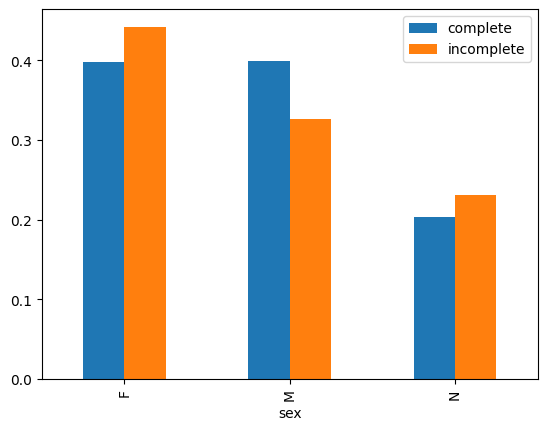

In [39]:
sg = (students.groupby('sex').count()['uuid']/len(students)).rename('complete')
mg = (missing_course_taken.groupby('sex').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

<Axes: xlabel='job_id'>

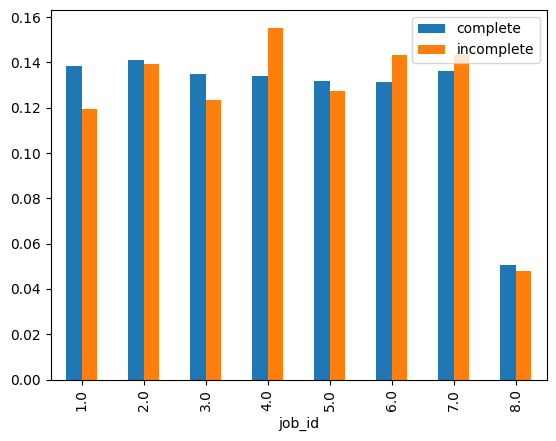

In [40]:
sg = (students.groupby('job_id').count()['uuid']/len(students)).rename('complete')
mg = (missing_course_taken.groupby('job_id').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

<Axes: xlabel='age_group'>

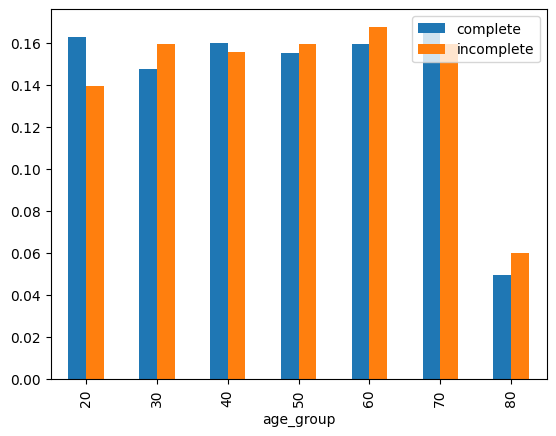

In [41]:
sg = (students.groupby('age_group').count()['uuid']/len(students)).rename('complete')
mg = (missing_course_taken.groupby('age_group').count()['uuid']/len(missing_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

A simple eye test of the distributions don't show anything out of the ordinary. It doesn't look as if any of the missing courses are students who haven't enrolled in a course yet, which would rule of Structurally Missing data. So I think we can conclude that this data is missing at random (MAR). Since there is only about 5% of the data missing, I think it's safe to remove it with little impact. However, instead of deleting the data completely, I will store it separately from the main students data in the event the analytics team would like to fill in this dataat a later date.

In [44]:
missing_data = pd.DataFrame()
missing_data = pd.concat([missing_data, missing_course_taken])
students = students.dropna(subset = ['num_course_taken'])

In [45]:
#sanity check
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4749 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4749 non-null   int64         
 1   name                    4749 non-null   object        
 2   dob                     4749 non-null   datetime64[ns]
 3   sex                     4749 non-null   object        
 4   job_id                  4744 non-null   float64       
 5   num_course_taken        4749 non-null   float64       
 6   current_career_path_id  4298 non-null   float64       
 7   time_spent_hrs          4298 non-null   float64       
 8   age                     4749 non-null   int64         
 9   age_group               4749 non-null   int64         
 10  email                   4749 non-null   object        
 11  street                  4749 non-null   object        
 12  city                    4749 non-null   object       

#### `job_id`
Since the missing data is categorical, we cannot impute the data. If the data is MAR, there are only a few options:
* delete the data due to low percentage of affected rows
* replace with the most frequently used value
* develop a classifcation model to predict the missing category

In [46]:
missing_job_id = students[students[['job_id']].isnull().any(axis=1)]
missing_job_id

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
162,163,Glen Riley,2002-08-22,M,NaN,8.0,3.0,5.70,22,20,glen_riley4484@hmail.com,P.O. Box 37267,Cornlea village,Tennessee,19192
757,758,Mercedez Vorberg,2002-03-25,F,NaN,15.0,4.0,4.14,22,20,mercedez6297@woohoo.com,284 Cedar Seventh,Virden village,Washington,60489
854,855,Kurt Ho,2002-05-29,M,NaN,0.0,8.0,23.72,22,20,ho6107@inlook.com,P.O. Box 27254,Olin,New Hampshire,60067
1029,1030,Penny Gaines,2002-03-01,N,NaN,15.0,4.0,16.25,22,20,gaines2897@hmail.com,138 Misty Vale,Stockton borough,West Virginia,53630
1542,1543,Frederick Reilly,2002-11-13,M,NaN,7.0,9.0,21.32,22,20,frederick_reilly6971@woohoo.com,P.O. Box 40769,Quakervillage,Maryland,96218


Because there are only 5 rows with missing job id data, I can deduce that this is an example of data MAR. Therefore I think it makes sense to just drop the data

In [48]:
missing_data = pd.concat([missing_data, missing_job_id])
students = students.dropna(subset=['job_id'])

In [49]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   float64       
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4293 non-null   float64       
 7   time_spent_hrs          4293 non-null   float64       
 8   age                     4744 non-null   int64         
 9   age_group               4744 non-null   int64         
 10  email                   4744 non-null   object        
 11  street                  4744 non-null   object        
 12  city                    4744 non-null   object       

#### `current_career_path_id`
Similar to `job_id`, this column is categorical so we can apply the same conclusions if this data is also MAR

In [50]:
missing_path_id = students[students[['current_career_path_id']].isnull().any(axis=1)]
missing_path_id

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code
15,16,Norene Dalton,1976-04-30,F,6.0,0.0,NaN,NaN,48,40,norene_dalton9509@hmail.com,130 Wishing Essex,Branch,Ohio,13616
19,20,Sofia van Steenbergen,1990-02-21,N,7.0,13.0,NaN,NaN,34,30,vansteenbergen8482@inlook.com,634 Clear Barn Dell,Beaman,Georgia,33288
30,31,Christoper Warner,1989-12-28,M,2.0,5.0,NaN,NaN,35,30,warner5906@coldmail.com,556 Stony Highlands,Drain,Illinois,01973
49,50,Antony Horne,1996-05-29,M,3.0,2.0,NaN,NaN,28,20,antony577@coldmail.com,P.O. Box 78685,Lenox,Texas,15516
54,55,Omar Bunk,1955-11-08,M,3.0,14.0,NaN,NaN,69,60,omar1245@coldmail.com,445 Dale Hollow,Vermont village,South Carolina,28329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,4905,Eduardo Daniel,2004-06-18,M,8.0,12.0,NaN,NaN,20,20,daniel5073@inlook.com,598 Deer Trace,Forest Grove,North Carolina,45038
4922,4923,Francisco van Ede,1961-04-26,M,7.0,5.0,NaN,NaN,63,60,vanede7845@coldmail.com,282 Fourth Trace,Carter Lake,Ohio,63511
4948,4949,Dewitt van Malsem,1949-03-08,M,4.0,7.0,NaN,NaN,75,70,dewitt4635@inlook.com,423 Course Trail,Wilmot,Hawaii,18996
4956,4957,Todd Stamhuis,1961-06-15,M,7.0,8.0,NaN,NaN,63,60,todd8019@woohoo.com,251 Grand Rose Underpass,Niagara,Pennsylvania,03430


A quick examination of the rows with missing career path ids are also missing time spent on course, we may be able to conclude that there are students are not currently taking classes

In [51]:
missing_path_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 451 entries, 15 to 4974
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    451 non-null    int64         
 1   name                    451 non-null    object        
 2   dob                     451 non-null    datetime64[ns]
 3   sex                     451 non-null    object        
 4   job_id                  451 non-null    float64       
 5   num_course_taken        451 non-null    float64       
 6   current_career_path_id  0 non-null      float64       
 7   time_spent_hrs          0 non-null      float64       
 8   age                     451 non-null    int64         
 9   age_group               451 non-null    int64         
 10  email                   451 non-null    object        
 11  street                  451 non-null    object        
 12  city                    451 non-null    object       

As hypothesized, where there are missing career path ids, there are also missing time spent on course, which concludes that the data ins structurally missing. In order to fix this, I will create a new path id and fill in the missing time spent with zeroes.

In [52]:
students['current_career_path_id'].unique()

array([ 1.,  8.,  9.,  3.,  6., 10.,  5., nan,  4.,  7.,  2.])

In [54]:
students['current_career_path_id'] = np.where(students['current_career_path_id'].isnull(), 0, students['current_career_path_id'])
students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isnull(), 0, students['time_spent_hrs'])

/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_35170/3702212675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['current_career_path_id'] = np.where(students['current_career_path_id'].isnull(), 0, students['current_career_path_id'])
/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_35170/3702212675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isnull(), 0, students['time_spent_hrs'])


In [55]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4744 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   float64       
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4744 non-null   float64       
 7   time_spent_hrs          4744 non-null   float64       
 8   age                     4744 non-null   int64         
 9   age_group               4744 non-null   int64         
 10  email                   4744 non-null   object        
 11  street                  4744 non-null   object        
 12  city                    4744 non-null   object       

## Working with the Courses table

In [56]:
display(courses)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [57]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 372.0+ bytes


Since this table is much smaller than the students and after inspecting the table above, it won't require much cleaning. The only thing that needs to be done is to add in the new career path to match the path ids in the student table.

In [58]:
not_applicable = {'career_path_id': 0,
                  'career_path_name': 'not applicable',
                  'hours_to_complete': 0}
courses.loc[len(courses)] = not_applicable
display(courses)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


### Working with the student jobs table

In [59]:
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


In [60]:
student_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 444.0+ bytes


Similar to the courses table, student jobs is a small table however there are a few duplicates based on the `job_id` column. So I will only by removing those duplicates from this table

In [61]:
student_jobs.drop_duplicates(inplace=True)
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


## Joining tables
Before we begin to join the tables, I will convert the id columns to integers now that there are no missing values


In [62]:
students['job_id'] = students['job_id'].astype(int)
students['current_career_path_id'] = students['current_career_path_id'].astype(int)

/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_35170/3064188340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['job_id'] = students['job_id'].astype(int)
/var/folders/8h/x0jbyn051fs3cqqsc0yx7k600000gn/T/ipykernel_35170/3064188340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  students['current_career_path_id'] = students['current_career_path_id'].astype(int)


In [66]:
codemycade_final = students.merge(courses, left_on = 'current_career_path_id', right_on = 'career_path_id', how = 'left')
codemycade_final = codemycade_final.merge(student_jobs, on = 'job_id', how = 'left')

codemycade_final.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,age_group,email,street,city,state,zip_code,career_path_id,career_path_name,hours_to_complete,job_category,avg_salary
0,1,Annabelle Avery,1943-07-03,F,7,6.0,1,4.99,81,80,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736,1,data scientist,20,HR,80000
1,2,Micah Rubio,1991-02-07,M,7,5.0,8,4.40,33,30,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439,8,android developer,27,HR,80000
2,3,Hosea Dale,1989-12-07,M,7,8.0,8,6.74,35,30,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637,8,android developer,27,HR,80000
3,4,Mariann Kirk,1988-07-31,F,6,7.0,9,12.31,36,30,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242,9,machine learning engineer,35,education,61000
4,5,Lucio Alexander,1963-08-31,M,7,14.0,3,5.64,61,60,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737,3,data analyst,12,HR,80000


In [68]:
codemycade_final.info()
con.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    4744 non-null   int64         
 1   name                    4744 non-null   object        
 2   dob                     4744 non-null   datetime64[ns]
 3   sex                     4744 non-null   object        
 4   job_id                  4744 non-null   int64         
 5   num_course_taken        4744 non-null   float64       
 6   current_career_path_id  4744 non-null   int64         
 7   time_spent_hrs          4744 non-null   float64       
 8   age                     4744 non-null   int64         
 9   age_group               4744 non-null   int64         
 10  email                   4744 non-null   object        
 11  street                  4744 non-null   object        
 12  city                    4744 non-null   object  

## Upserting cleansed and missing data tables into new DB

In [69]:
sqlite_con = sqlite3.connect('cademycode_cleansed.db')
codemycade_final.to_sql('codemycade_aggregated', sqlite_con, if_exists = 'replace', index=False)

4744

In [70]:
db_df = pd.read_sql_query('SELECT * FROM codemycade_aggregated', sqlite_con)
db_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4744 entries, 0 to 4743
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int64  
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   int64  
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   int64  
 9   age_group               4744 non-null   int64  
 10  email                   4744 non-null   object 
 11  street                  4744 non-null   object 
 12  city                    4744 non-null   object 
 13  state                   4744 non-null   object 
 14  zip_code                4744 non-null   

In [71]:
missing_data.to_sql('incomplete_data', sqlite_con, if_exists = 'replace', index=False)

256

In [72]:
missing_df = pd.read_sql_query('SELECT * FROM incomplete_data', sqlite_con)
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    256 non-null    int64  
 1   name                    256 non-null    object 
 2   dob                     256 non-null    object 
 3   sex                     256 non-null    object 
 4   job_id                  251 non-null    float64
 5   num_course_taken        5 non-null      float64
 6   current_career_path_id  236 non-null    float64
 7   time_spent_hrs          236 non-null    float64
 8   age                     256 non-null    int64  
 9   age_group               256 non-null    int64  
 10  email                   256 non-null    object 
 11  street                  256 non-null    object 
 12  city                    256 non-null    object 
 13  state                   256 non-null    object 
 14  zip_code                256 non-null    ob

In [73]:
sqlite_con.close()

In [74]:
db_df.to_csv('cademycode_cleansed.csv')